<img src="proyecto_final_portada.png" alt="Portada Proyecto Final" style="height: 600px; width:600px;"/>



# PROYECTO DE PREDICCIÓN DE CHURN - MUNDOS E  

El sector de las telecomunicaciones (telecom) en India está cambiando rápidamente, con la creación de más y más empresas de telecomunicaciones y muchos clientes decidiendo cambiar entre proveedores. "Churn" se refiere al proceso en el que los clientes o suscriptores dejan de utilizar los servicios o productos de una empresa. Comprender los factores que influyen en la retención de clientes como también lograr predecir la posibilidad de "churn" es crucial para que las empresas de telecomunicaciones mejoren la calidad de sus servicios y la satisfacción del cliente. Como científicos de datos en este proyecto, nuestro objetivo es explorar la compleja dinámica del comportamiento y la demografía de los clientes en el sector de las telecomunicaciones en India para predecir la "salida" o "churn" de los clientes, utilizando dos conjuntos de datos completos de cuatro importantes socios de telecomunicaciones: Airtel, Reliance Jio, Vodafone y BSNL:

- `telecom_demographics.csv` contiene información relacionada con la demografía de los clientes indios:

| Variable             | Descripción                                      |
|----------------------|--------------------------------------------------|
| `customer_id `         | Identificador único de cada cliente.             |
| `telecom_partner `     | El socio de telecomunicaciones asociado con el cliente.|
| `gender `              | El género del cliente.                      |
| `age `                 | La edad del cliente.                         |
| `state`                | El estado indio en el que se encuentra el cliente.|
| `city`                 | La ciudad en la que se encuentra el cliente.       |
| `pincode`              | El código PIN de la ubicación del cliente.          |
| `registration_event` | Cuando el cliente se registró con el socio de telecomunicaciones.|
| `num_dependents`      | El número de dependientes (por ejemplo, niños) que tiene el cliente.|
| `estimated_salary`     | El salario estimado del cliente.                 |

- `telecom_usage` contiene información sobre los patrones de uso de los clientes indios:

| Variable   | Descripción                                                  |
|------------|--------------------------------------------------------------|
| `customer_id` | Identificador único de cada cliente.                         |
| `calls_made` | El número de llamadas realizadas por el cliente.                    |
| `sms_sent`   | El número de mensajes de SMS enviados por el cliente.             |
| `data_used`  | La cantidad de datos utilizada por el cliente.                     |
| `churn`    | Variable binaria que indica si el cliente ha cancelado o no (1 = cancelado, 0 = no cancelado).|

---

### Deseamos responder nuestra hipótesis sobre qué variables influyen en la decisión de renuncia de un cliente, para ello realizaremos un Análisis exploratorio de datos y luego entrenamiento de modelos ensamble, con el objetivo también de conocer el proceso de clasificación de los modelos. 

#### Estructura del notebook:
##### 1. Importación de librerías y dependencias 


In [298]:
#Importamos las librerías princiaples
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from machine_learning_utils import make_prediction, verify_results #Funciones que creamos para predecir y visualizar resultados en "machine_learning_utils.py"
from grafs import vars_categoricas_graf, multi_vars_graf, plot_max_churn, distribution_plot # Funciones que creamos para graficar multi variables categóricas.
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict

##### 2. Análisis exploratorio de los datos y variables relevantes


Leemos los datasets y procesamos los datos desde archivos locales .csv

In [299]:
#Lectura de los archivos .csv con pandas
df1 = pd.read_csv('telecom_demographics.csv')
df2 = pd.read_csv('telecom_usage.csv')

print(df1.shape, df2.shape)

(6500, 10) (6500, 5)


In [300]:
#Unimos los dos dataframes con la variable customer id
df_full = pd.merge(df1,df2,on='customer_id')
df_full.head(5)

,customer_id,telecom_partner,gender,age,state,city,pincode,registration_event,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn
0,15169,Airtel,F,26,Himachal Pradesh,Delhi,667173,2020-03-16,4,85979,75,21,4532,1
1,149207,Airtel,F,74,Uttarakhand,Hyderabad,313997,2022-01-16,0,69445,35,38,723,1
2,148119,Airtel,F,54,Jharkhand,Chennai,549925,2022-01-11,2,75949,70,47,4688,1
3,187288,Reliance Jio,M,29,Bihar,Hyderabad,230636,2022-07-26,3,34272,95,32,10241,1
4,14016,Vodafone,M,45,Nagaland,Bangalore,188036,2020-03-11,4,34157,66,23,5246,1


In [301]:
df_full.shape

(6500, 14)

El dataset tiene 6500 filas y 15 columnas luego del join

In [302]:
df_full.isna().sum()

customer_id           0
telecom_partner       0
gender                0
age                   0
state                 0
city                  0
pincode               0
registration_event    0
num_dependents        0
estimated_salary      0
calls_made            0
sms_sent              0
data_used             0
churn                 0
dtype: int64

In [303]:
df_full.duplicated().sum()

0

No hay valores vacíos ni tampoco repetidos o duplicados.

In [304]:
df_full= df_full.drop(axis=1, columns=['customer_id', 'pincode']) #Eliminamos customer_id que ya no nos sirve

Modificación en cómo se registra el tiempo

In [305]:
df_full['registration_event'] = pd.to_datetime(df_full['registration_event']) #Convertimos a variable de tipo tiempo

df_full['year'] = df_full['registration_event'].dt.year #dividimos en año, mes y día
df_full['month'] = df_full['registration_event'].dt.month
df_full['day'] = df_full['registration_event'].dt.day
df_full.head(5)

,telecom_partner,gender,age,state,city,registration_event,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn,year,month,day
0,Airtel,F,26,Himachal Pradesh,Delhi,2020-03-16,4,85979,75,21,4532,1,2020,3,16
1,Airtel,F,74,Uttarakhand,Hyderabad,2022-01-16,0,69445,35,38,723,1,2022,1,16
2,Airtel,F,54,Jharkhand,Chennai,2022-01-11,2,75949,70,47,4688,1,2022,1,11
3,Reliance Jio,M,29,Bihar,Hyderabad,2022-07-26,3,34272,95,32,10241,1,2022,7,26
4,Vodafone,M,45,Nagaland,Bangalore,2020-03-11,4,34157,66,23,5246,1,2020,3,11


Podemos comenzar entonces, con el Análisis estadístico de las variables númericas del dataset

In [306]:
df_full.describe(exclude='O') 

,age,registration_event,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn,year,month,day
count,6500.000000,6500,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000
mean,46.108615,2021-08-28 06:53:23.446153728,1.982308,85529.193385,49.789538,24.257846,5000.956308,0.200462,2021.189077,6.142769,15.699385
min,18.000000,2020-01-01 00:00:00,0.000000,20001.000000,-10.000000,-5.000000,-969.000000,0.000000,2020.000000,1.000000,1.000000
25%,32.000000,2020-10-27 18:00:00,1.000000,52905.000000,25.000000,12.000000,2493.750000,0.000000,2020.000000,3.000000,8.000000
50%,46.000000,2021-08-25 12:00:00,2.000000,85286.500000,50.000000,25.000000,4975.500000,0.000000,2021.000000,6.000000,16.000000
75%,60.000000,2022-06-26 06:00:00,3.000000,118817.500000,75.000000,37.000000,7504.250000,0.000000,2022.000000,9.000000,23.000000
max,74.000000,2023-05-03 00:00:00,4.000000,149977.000000,108.000000,53.000000,10919.000000,1.000000,2023.000000,12.000000,31.000000
std,16.443712,NaN,1.404659,37545.639180,29.799221,14.650736,2940.611928,0.400377,0.985401,3.474823,8.789380


Algunos datos relevantes del análisis estadísitico de la distribución de los datos:
- La edad promedio de los clientes de 46 años. La edad mínima es 18 y la edad máxima es de 74

- Estimated salary como genralmente sucede con los salarios tiene una desviación estandar enorme, implicando un desbalance entre la distribución de los salarios. 

- Aparecen números negativos en el mínimo de llamadas hechas, sms enviados y en la cantidad de datos utilizados. Deberemos decidir como se interpretarán y usarán estos datos.



Análisis estadístico de las variables categóricas del dataset

In [307]:
df_full.describe(include='O').T

,count,unique,top,freq
telecom_partner,6500,4,Reliance Jio,1658
gender,6500,2,M,3909
state,6500,28,Karnataka,260
city,6500,6,Delhi,1128


El análisis de variables categóricas nos permite revisar la frecuencia y la cantidad de valores nulos:

 - No hay valores nulos, tenemos 4 empresas, 2 géneros y con mayor frecuencia masculinos.
 
 - La ciudad con más frecuencia es Delhi, relacionada con el estado Karnataka. 


In [308]:
sns.set_palette('deep') #Seteamos la paleta de colores

> ¿Qué sucede con las compañías de telecomunicaciones?

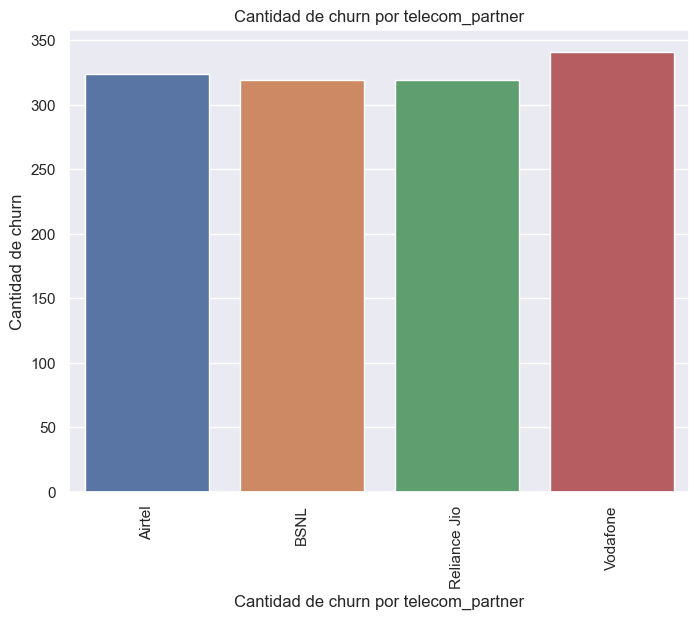

In [309]:
vars_categoricas_graf(df_full, 'telecom_partner', 'churn')

In [310]:
df_full.columns

Index(['telecom_partner', 'gender', 'age', 'state', 'city',
       'registration_event', 'num_dependents', 'estimated_salary',
       'calls_made', 'sms_sent', 'data_used', 'churn', 'year', 'month', 'day'],
      dtype='object')

Vodafone lidera la tabla de compañías de telecom con el 26,17% de las bajas totales. Las otras compañías tienen un porcentaje similar.

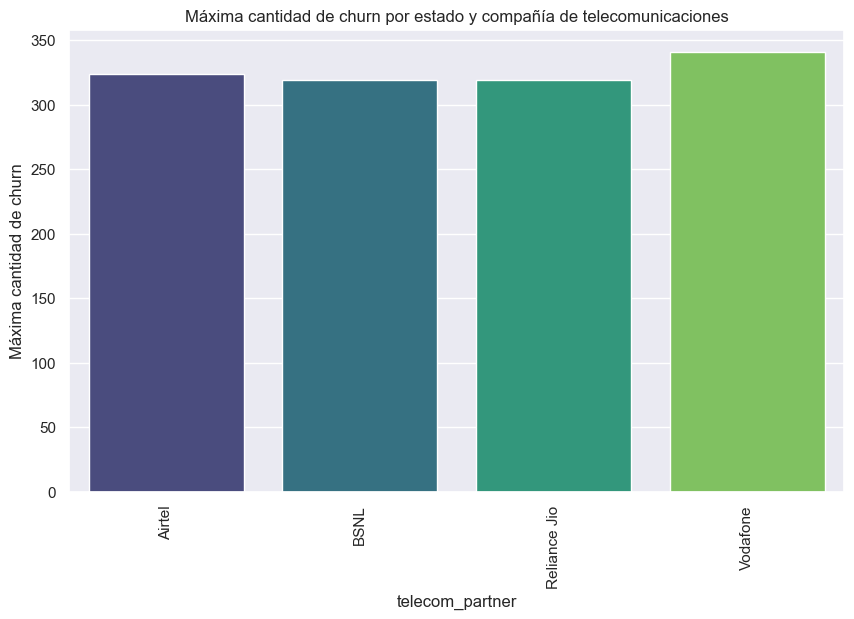

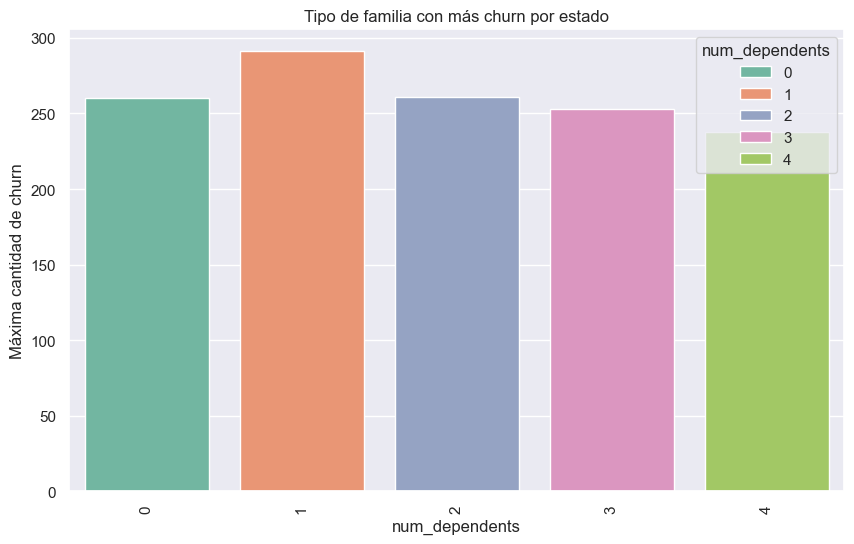

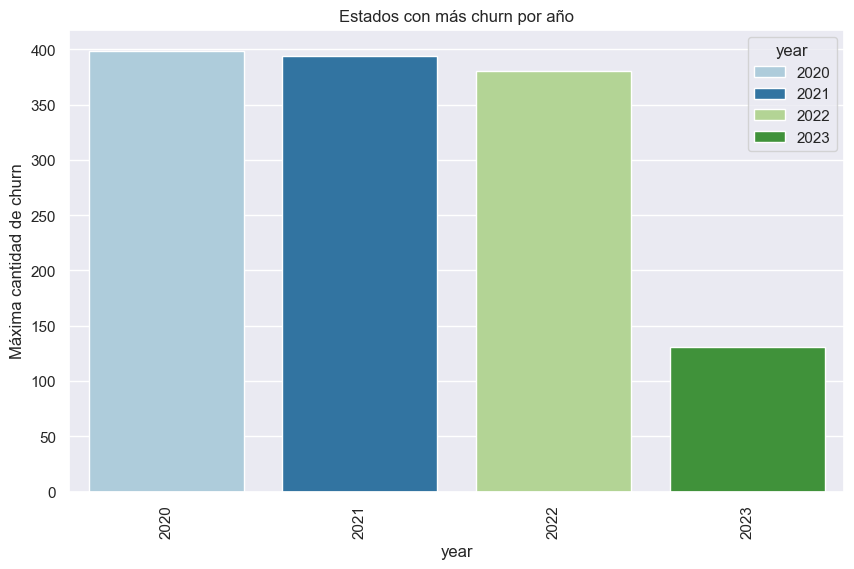

In [311]:
# Llamar a la función para cada caso
plot_max_churn(df_full, 'telecom_partner', 'churn', 'telecom_partner', 'Máxima cantidad de churn por estado y compañía de telecomunicaciones', palette='viridis')
plot_max_churn(df_full, 'num_dependents', 'churn', 'num_dependents', 'Tipo de familia con más churn por estado', 'Set2')
plot_max_churn(df_full, 'year', 'churn', 'year', 'Estados con más churn por año', 'Paired')

Por compañía de telecomunicaciones, el gráfico muestra que Reliance Jio tuvo el menor porcentaje de abandonos, seguido de Airtel, Vodafone y BSNL.

Por número de dependientes, el gráfico muestra que los hogares con dos o más dependientes tenían un mayor porcentaje de abandonos que los hogares con un solo dependiente o ningún dependiente.

Por año, el gráfico muestra que el porcentaje de abandonos aumentó en 2022 en comparación con 2021.

Interpretaciones específicas

Reliance Jio es la compañía de telecomunicaciones más popular en la India, con una cuota de mercado del 36,8% en 2022. Su éxito se debe a una combinación de factores, que incluyen tarifas competitivas, una amplia cobertura y una sólida red de distribución.
La India tiene una población joven y en crecimiento, con un alto porcentaje de personas que viven en hogares con dos o más dependientes. Esto probablemente contribuya al mayor porcentaje de abandonos en estos hogares.
El aumento del porcentaje de abandonos en 2022 puede deberse a una serie de factores, como la inflación, la competencia más intensa y los cambios en las preferencias de los consumidores.

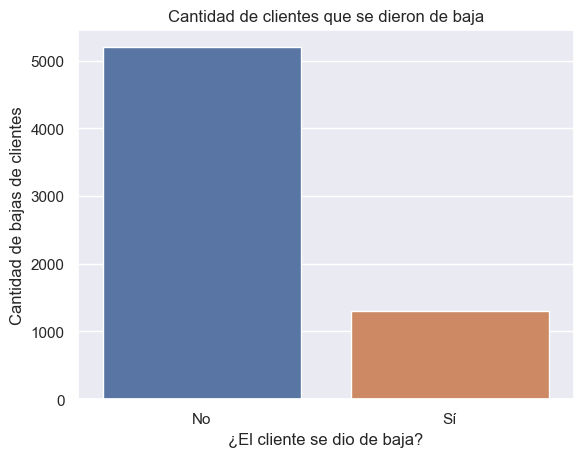

  churn  count
0    No   5197
1    Sí   1303


In [312]:
vars_categoricas_graf(df_full, 'churn', 'churn')

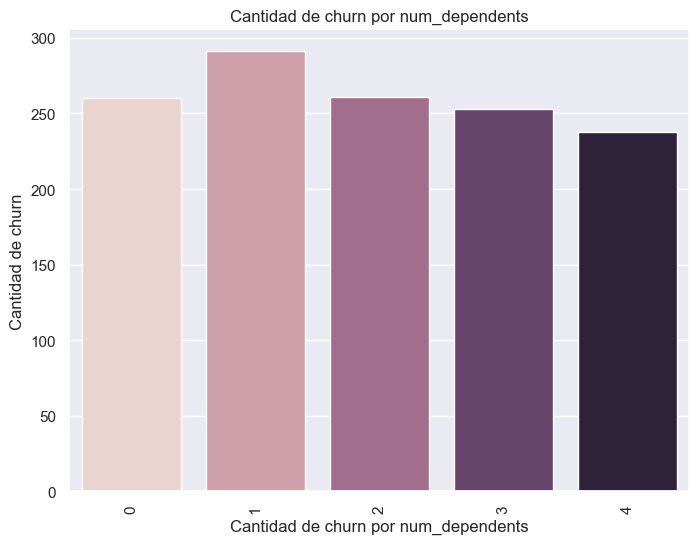

In [313]:
vars_categoricas_graf(df_full, 'num_dependents', 'churn')

Podemos ver que nuestro tipo de predicción es hacia una clase desbalanceada, que representa aproximadamente el 20% del total de posibilidades.

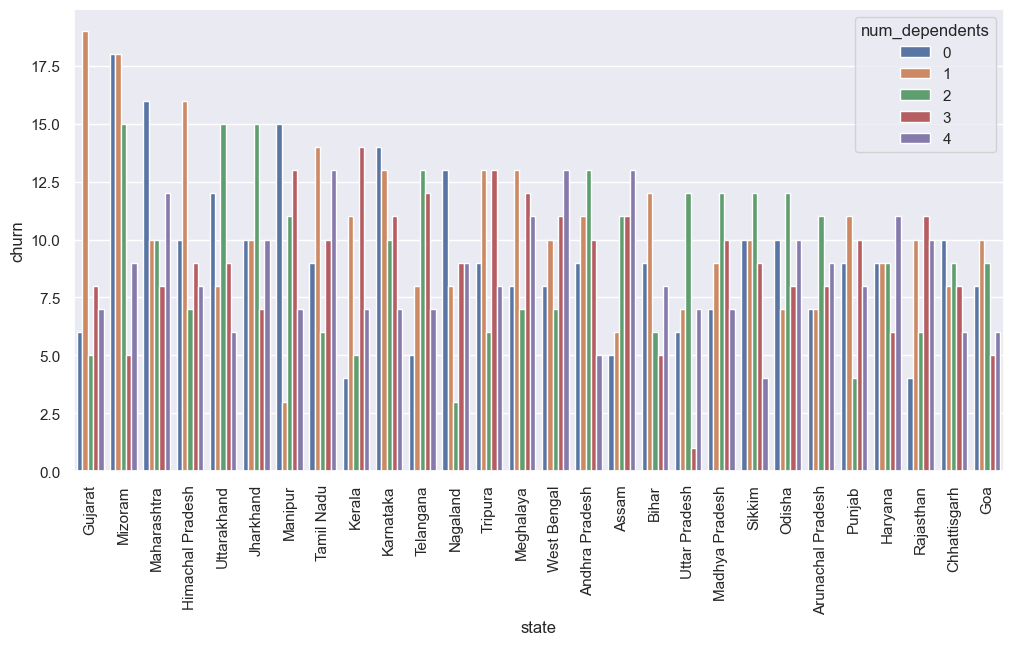

In [314]:
vista_group = df_full.groupby(['state', 'num_dependents'])['churn'].sum().reset_index().sort_values(by='churn', ascending=False)

plt.subplots(figsize=(12,6))

sns.barplot(data= vista_group, x='state', y='churn', hue='num_dependents',palette='deep')

plt.xticks(rotation=90)

plt.show()

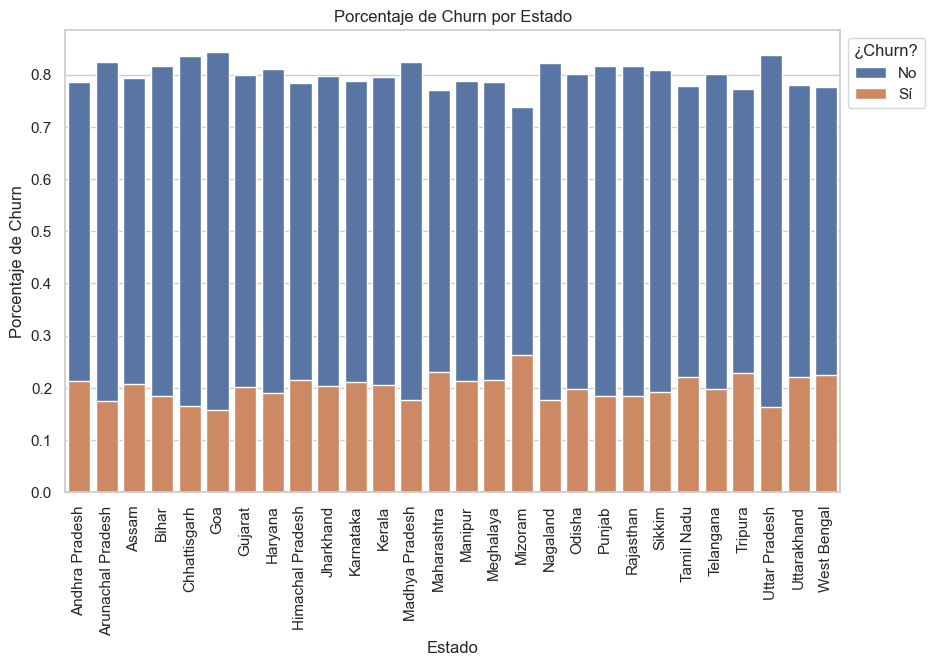

In [315]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular el porcentaje de churn 0 y churn 1 por estado
percent_churn_by_state = df_full.groupby('state')['churn'].value_counts(normalize=True).unstack().reset_index()

# Configurar el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Crear el gráfico de barras apiladas
plt.figure(figsize=(10, 6))
sns.barplot(x='state', y=0, data=percent_churn_by_state, label='No')
sns.barplot(x='state', y=1, data=percent_churn_by_state, label='Sí')

# Configuraciones adicionales
plt.title('Porcentaje de Churn por Estado')
plt.xlabel('Estado')
plt.ylabel('Porcentaje de Churn')
plt.xticks(rotation=90)
plt.legend(title='¿Churn?', loc='upper left', bbox_to_anchor=(1, 1))

# Mostrar el gráfico
plt.show()


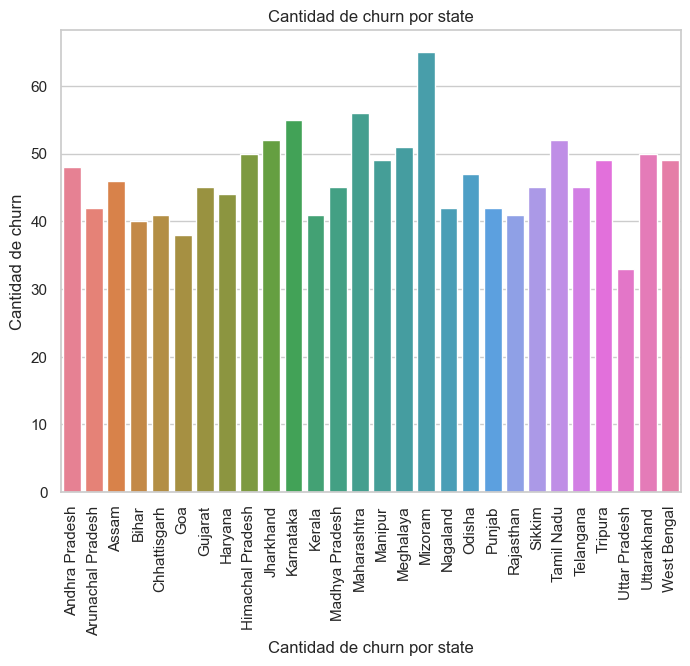

In [316]:
vars_categoricas_graf(df_full, 'state', 'churn')

Parecer ser que el estado de Mizoram es el que mayor cantidad de bajas presentas, podría ser un dato clave para preguntar qué sucedió en las ciudades del estado.

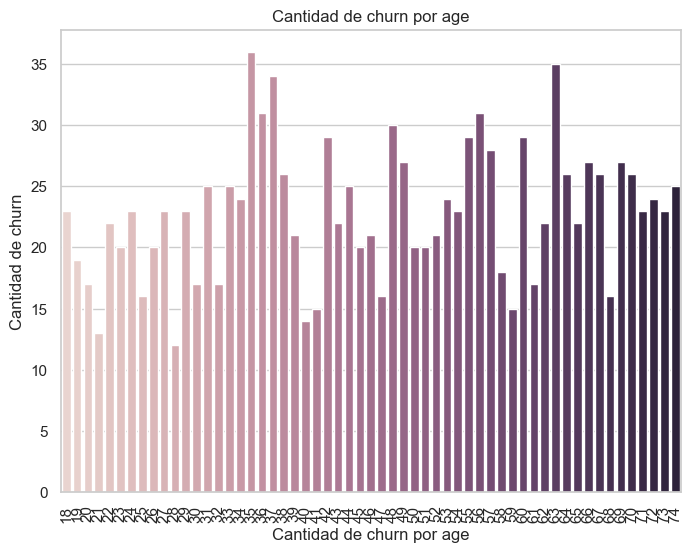

In [317]:
vars_categoricas_graf(df_full, 'age', 'churn')

Es interesante ver que hay un alto índice de renuncias entre los 35,36,37 años y los 56,60 y 63 años. 

In [318]:
df_full['telecom_partner'].value_counts()

telecom_partner
Reliance Jio    1658
BSNL            1635
Vodafone        1609
Airtel          1598
Name: count, dtype: int64

Si bien todas las empresas tienen una cantidad de renuncias similares, podemos ver que Vodafone lidera en las que más bajas tiene t podríamos decir que no es de las que más clientes tienen, esto es una llamada de atención para Vodafone.

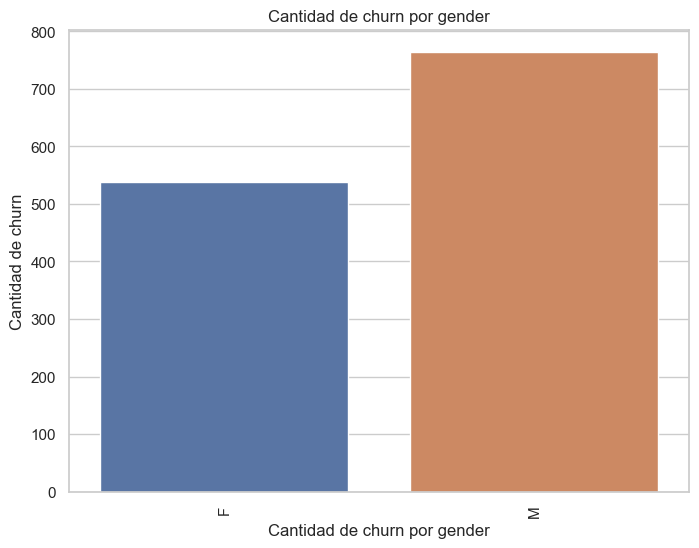

In [319]:
vars_categoricas_graf(df_full, 'gender', 'churn')

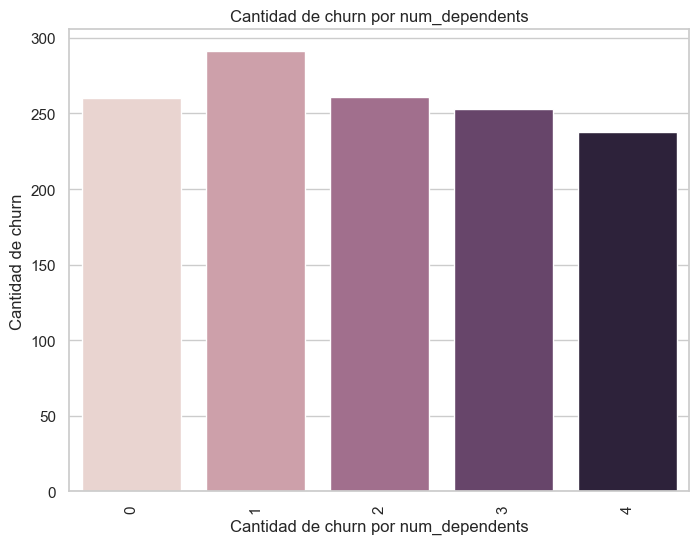

In [320]:
vars_categoricas_graf(df_full, 'num_dependents', 'churn')

Las personas con 1 hijo tienen mayor probabilidad de renunciar, sin embargo, no es una gran probabilidad, vemos una distribución similar entre los otras opciones.

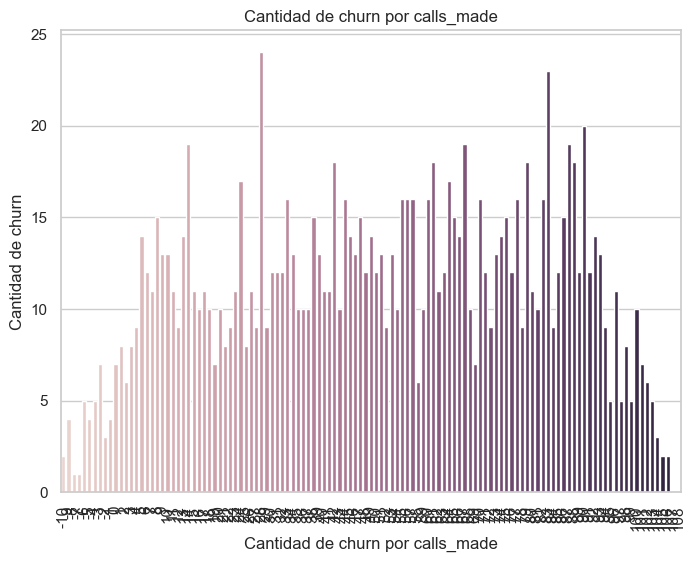

In [321]:
vars_categoricas_graf(df_full, 'calls_made', 'churn')

Podemos ver que no hay una estricta relación entre la cantidad de llamadas y las bajas. 

Podemos notar que hay mayor bajas en niveles bajos y altos de llamadas realizadas. 

Esto puede que genere en las personas que llaman poco querer cambiar de plan (porque pueden estar pagando un precio más elevado del uso que le dan al servicio o bien, personas que realizan muchas llamadas y reciben facturas con precios muy elevados). 

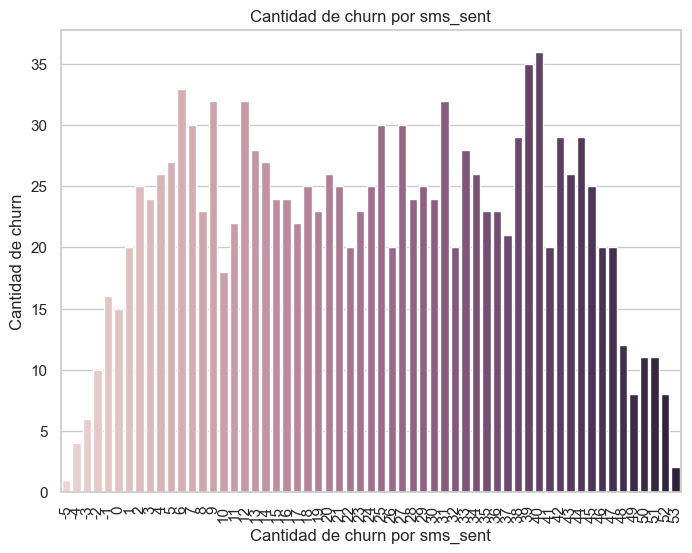

In [322]:
vars_categoricas_graf(df_full, 'sms_sent', 'churn')

En el caso de sms enviados, sucede algo muy similar con llamadas realizadas.

##### Veamos que sucede con la distribución de las variables númericas

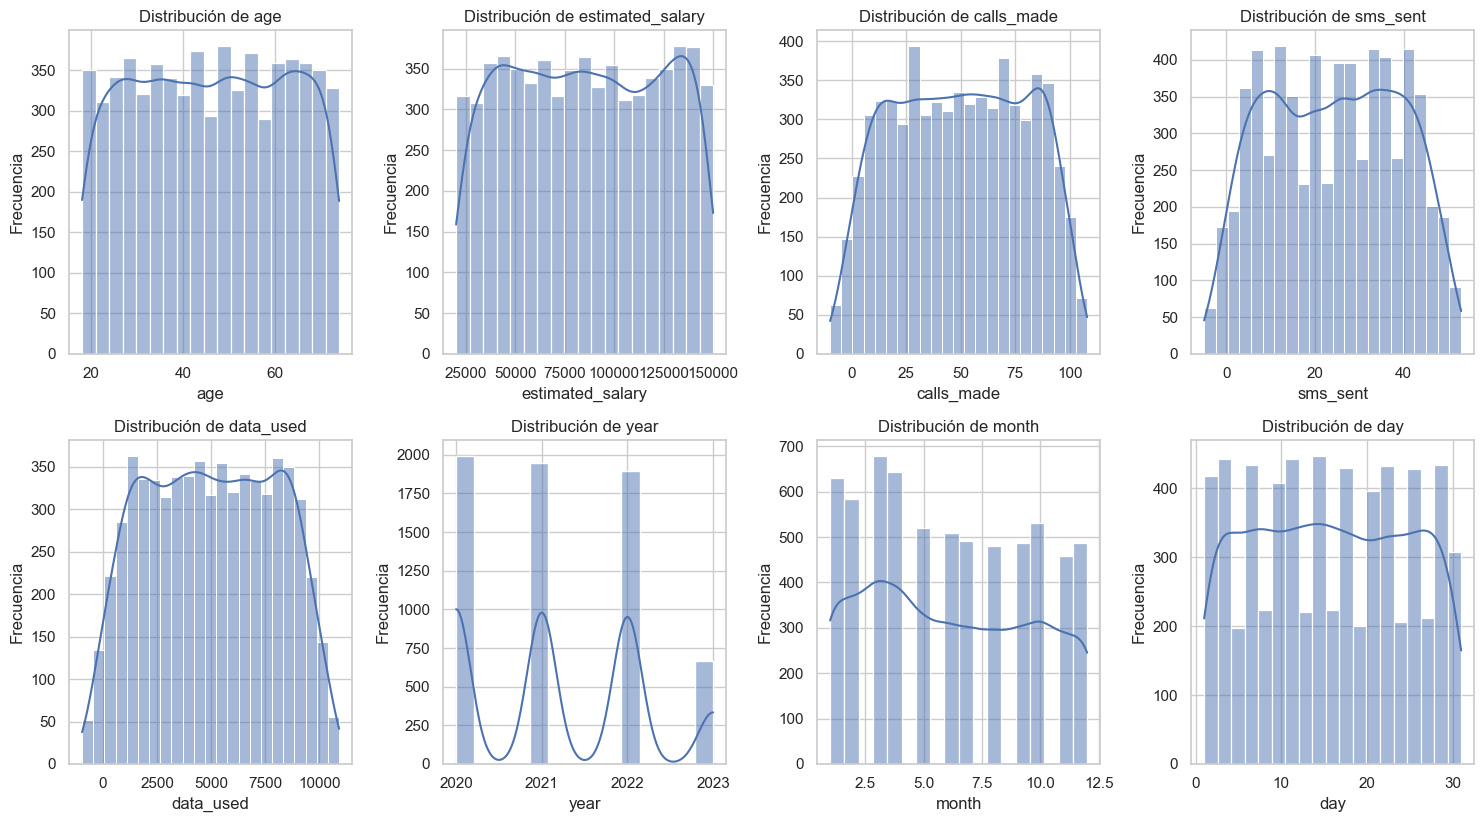

In [323]:
# Obtener columnas numéricas excluyendo algunas
columnas_numericas = df_full.select_dtypes(include=['int', 'float']).columns
columnas_excluidas = ['churn', 'customer_id', 'num_dependents']

# Filtrar columnas numéricas
columnas_para_graficar = [col for col in columnas_numericas if col not in columnas_excluidas]

# Llamar a la función con subplots
distribution_plot(df_full, columnas_para_graficar, nrows=3, ncols=4)  # Ajusta nrows y ncols según sea necesario

- Por **edad**, el gráfico muestra que la mayoría de los usuarios tienen entre 20 y 40 años. Esto es consistente con la población general de la India, que tiene una pirámide poblacional joven.

- Por **salario estimado**, el gráfico muestra que los usuarios con un salario estimado más alto realizan más llamadas y envían más mensajes de texto. Esto es probablemente porque tienen más acceso a teléfonos inteligentes y datos móviles.

- Por **llamadas realizadas**, el gráfico muestra que los usuarios de los estados del sur de la India realizan más llamadas que los usuarios de los estados del norte de la India. Esto puede deberse a una serie de factores, como la densidad de población, la distancia entre las ciudades y las preferencias culturales.

- Por **mensajes de texto enviados**, el gráfico muestra que los usuarios de los estados del norte de la India envían más mensajes de texto que los usuarios de los estados del sur de la India. Esto puede deberse a una serie de factores, como la disponibilidad de servicios de mensajería instantánea, las preferencias culturales y los costos de los mensajes de texto.

**Interpretaciones específicas**

La distribución de la edad de los usuarios es similar a la población general de la India.
Los usuarios con un salario estimado más alto tienen más acceso a teléfonos inteligentes y datos móviles.
Los usuarios de los estados del sur de la India realizan más llamadas que los usuarios de los estados del norte de la India.
Los usuarios de los estados del norte de la India envían más mensajes de texto que los usuarios de los estados del sur de la India.

**Conclusiones**

Los datos de la imagen sugieren que los usuarios de servicios de telecomunicaciones en la India son diversos en términos de edad, salario estimado, uso de llamadas y uso de mensajes de texto. Las compañías de telecomunicaciones deben tener en cuenta estas diferencias al diseñar sus ofertas de servicios.

A continuación se presentan algunas preguntas específicas que se pueden responder con los datos de la imagen:

##### 1. ¿Cuál es la edad promedio de los usuarios de servicios de telecomunicaciones en la India?
##### 2. ¿Cuál es el salario estimado promedio de los usuarios de servicios de telecomunicaciones en la India?
##### 3. ¿Cuáles son los estados con la mayor y la menor cantidad de llamadas realizadas
##### 4. ¿Cuáles son los estados con la mayor y la menor cantidad de mensajes de texto enviados?

*Estas preguntas pueden ayudar a las compañías de telecomunicaciones a comprender mejor a sus clientes y a desarrollar estrategias de marketing más efectivas.*


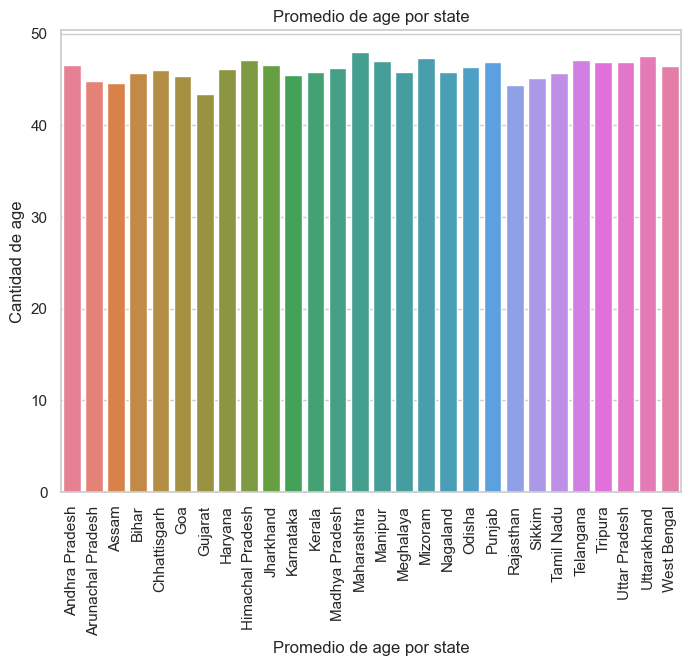

In [324]:
# Ejemplo de uso con la media (mean)
vars_categoricas_graf(df_full, 'state', 'age', use_mean=True, title=None)

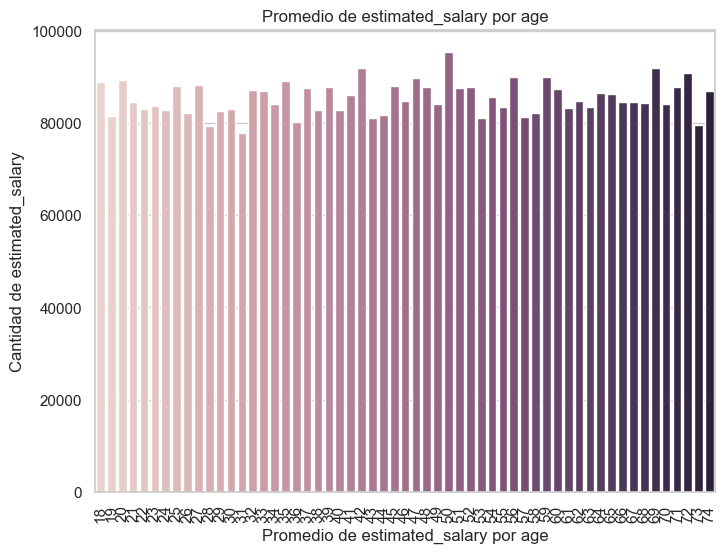

In [325]:
vars_categoricas_graf(df_full, 'age', 'estimated_salary', use_mean=True, title=None)

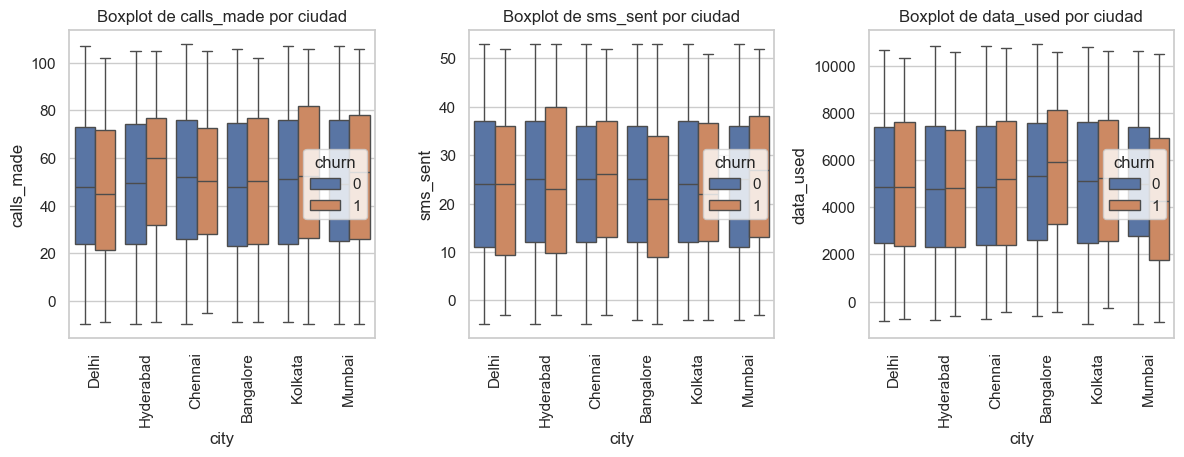

In [326]:
# Configurar subplots
plt.figure(figsize=(12, 8))

# Primer subplot
plt.subplot(2, 3, 1)
sns.boxplot(data=df_full, x='city', y='calls_made', hue='churn')
plt.title('Boxplot de calls_made por ciudad')
plt.xticks(rotation=90)

# Segundo subplot
plt.subplot(2,3, 2)
sns.boxplot(data=df_full, x='city', y='sms_sent', hue='churn')
plt.title('Boxplot de sms_sent por ciudad')
plt.xticks(rotation=90)

# Tercer subplot
plt.subplot(2,3, 3)
sns.boxplot(data=df_full, x='city', y='data_used', hue='churn')
plt.title('Boxplot de data_used por ciudad')
plt.xticks(rotation=90)

# Ajustar el diseño
plt.tight_layout()
plt.show()


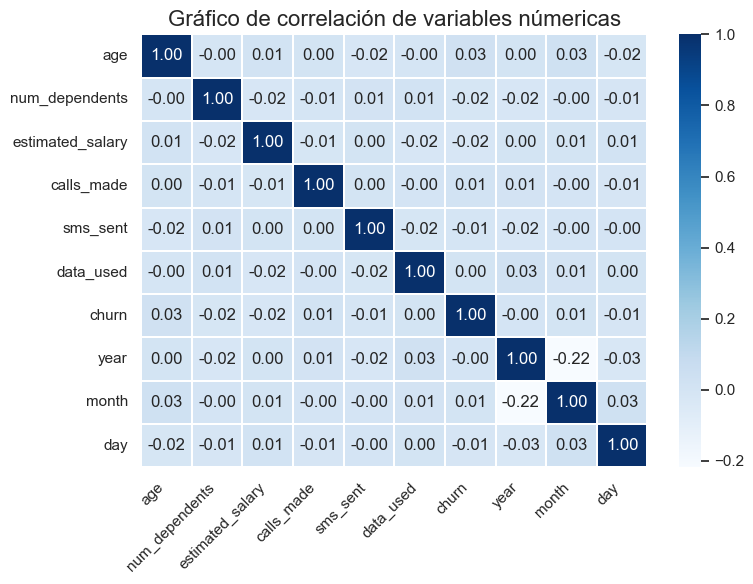

In [327]:
corr = df_full.corr(numeric_only=True)
plt.figure(figsize=(8, 6))  # Tamaño de la figura
sns.set(font_scale=1)  # Escala del tamaño de la fuente
sns.heatmap(corr, cmap='Blues', annot=True, fmt='.2f', linewidths=.2)

# Configuraciones adicionales (opcional)
plt.title('Gráfico de correlación de variables númericas', fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotación de etiquetas en el eje x
plt.yticks(rotation=0)  # Rotación de etiquetas en el eje y
plt.tight_layout()

# Mostrar el mapa de calor
plt.show()

No vemos ninguna relación directa o lineal con las variables númericas. Probemos con la variable de tiempo. Primero vamos a procesarla

In [328]:
df_full['registration_event'] = pd.to_datetime(df_full['registration_event']) #Convertimos a variable de tipo tiempo

df_full['year'] = df_full['registration_event'].dt.year #dividimos en año, mes y día
df_full['month'] = df_full['registration_event'].dt.month
df_full['day'] = df_full['registration_event'].dt.day
df_full.head(5)

,telecom_partner,gender,age,state,city,registration_event,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn,year,month,day
0,Airtel,F,26,Himachal Pradesh,Delhi,2020-03-16,4,85979,75,21,4532,1,2020,3,16
1,Airtel,F,74,Uttarakhand,Hyderabad,2022-01-16,0,69445,35,38,723,1,2022,1,16
2,Airtel,F,54,Jharkhand,Chennai,2022-01-11,2,75949,70,47,4688,1,2022,1,11
3,Reliance Jio,M,29,Bihar,Hyderabad,2022-07-26,3,34272,95,32,10241,1,2022,7,26
4,Vodafone,M,45,Nagaland,Bangalore,2020-03-11,4,34157,66,23,5246,1,2020,3,11


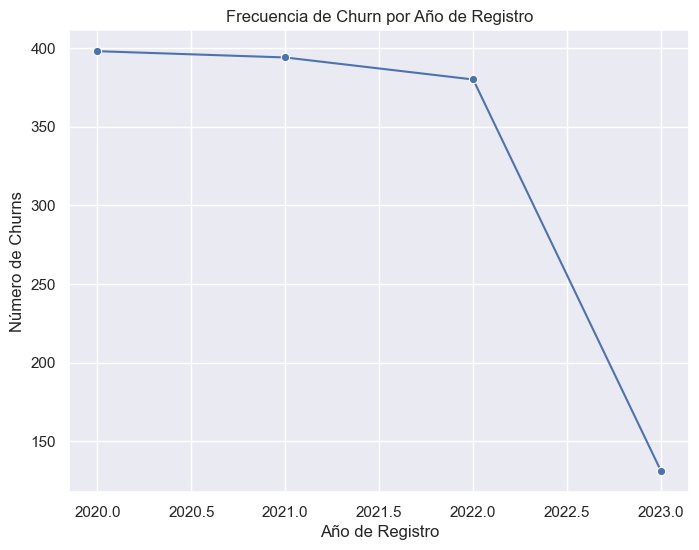

In [329]:
df_churn_by_year = df_full.groupby('year')['churn'].sum().reset_index()

# Gráfico de línea para visualizar la frecuencia de churn por año
plt.figure(figsize=(8, 6))
sns.lineplot(x='year', y='churn', data=df_churn_by_year, marker='o')
plt.title('Frecuencia de Churn por Año de Registro')
plt.xlabel('Año de Registro')
plt.ylabel('Número de Churns')
plt.show()


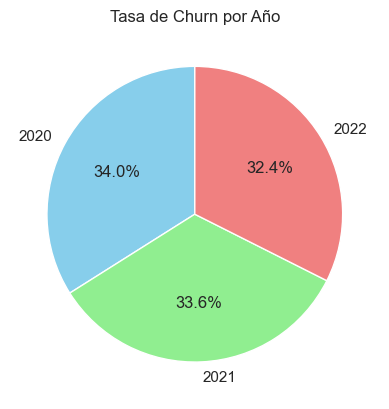

In [330]:
df_churn_by_year = df_full.groupby('year')['churn'].sum().reset_index()

years =df_churn_by_year['year'][0:3]

churn_rates = df_churn_by_year['churn'][0:3]

plt.pie(churn_rates, labels=years, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Tasa de Churn por Año')
plt.show()

Es muy interesante ver que el año en el que llega la pandemia (2020) se produce la mayor cantidad de bajas y esto puede ser debido a que mucha gente tuvo que dejar de trabajar debido al confinamiento y decidió darse de baja del servicio para reducir costos.

In [331]:
df_pre_processed = df_full.copy()

In [332]:
le = LabelEncoder() # Instanciamos LaberEncoder

enc = OneHotEncoder(handle_unknown='ignore') # Instanciamos One Hot Encoder

df_pre_processed['telecom_partner'] = le.fit_transform(df_pre_processed['telecom_partner'])

df_pre_processed = pd.get_dummies(df_pre_processed, columns=['gender'], drop_first=True) # Eliminamos una columna para evitar la dummy_trap o tramp de las variables dummys

df_pre_processed['state'] = le.fit_transform(df_pre_processed['state'])

df_pre_processed['city'] = le.fit_transform(df_pre_processed['city'])

df_pre_processed = df_pre_processed.drop(axis=1, columns='registration_event')

In [333]:
df_pre_processed['gender_M'] = df_pre_processed.gender_M.replace({False: 0, True: 1})

In [334]:
columns = ['calls_made', 'sms_sent','data_used']

for column in columns: # Bucle for para recorrer las columnas con negativos
    df_pre_processed[column] = df_pre_processed[column].clip(lower=0)

In [335]:
numerical_columns = ['age',
       'estimated_salary', 'calls_made', 'sms_sent', 'data_used']

scaler = MinMaxScaler()

for column in numerical_columns:
    df_pre_processed[column] = scaler.fit_transform(df_pre_processed[[column]])


In [336]:
df_pre_processed.head(5)

,telecom_partner,age,state,city,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn,year,month,day,gender_M
0,0,0.142857,8,2,4,0.507617,0.694444,0.396226,0.415056,1,2020,3,16,0
1,0,1.000000,26,3,0,0.380409,0.324074,0.716981,0.066215,1,2022,1,16,0
2,0,0.642857,9,1,2,0.430449,0.648148,0.886792,0.429343,1,2022,1,11,0
3,2,0.196429,3,3,3,0.109797,0.879630,0.603774,0.937906,1,2022,7,26,1
4,3,0.482143,17,0,4,0.108912,0.611111,0.433962,0.480447,1,2020,3,11,1


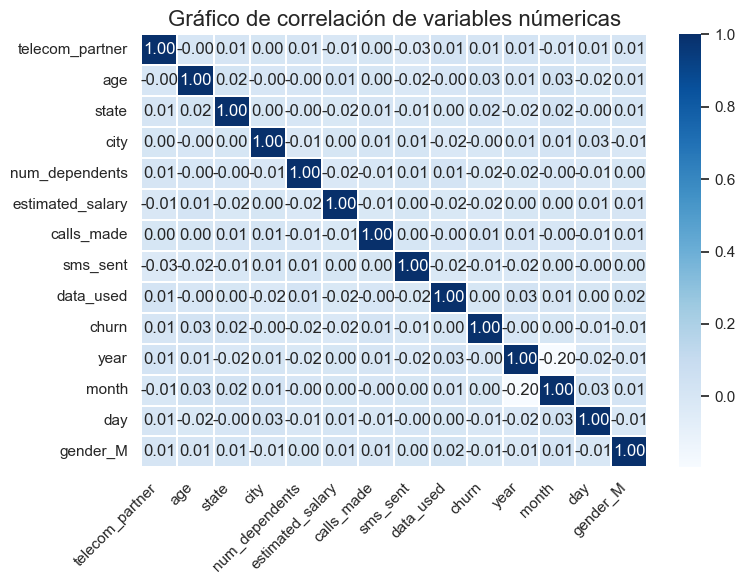

In [337]:
corr = df_pre_processed.corr(method='spearman')
plt.figure(figsize=(8, 6))  # Tamaño de la figura
sns.set(font_scale=1)  # Escala del tamaño de la fuente
sns.heatmap(corr, cmap='Blues', annot=True, fmt='.2f', linewidths=.2)

# Configuraciones adicionales (opcional)
plt.title('Gráfico de correlación de variables númericas', fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotación de etiquetas en el eje x
plt.yticks(rotation=0)  # Rotación de etiquetas en el eje y
plt.tight_layout()

# Mostrar el mapa de calor
plt.show()

In [338]:
X= df_pre_processed.drop(axis=1, columns='churn')
y= df_pre_processed['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, stratify=y, random_state=42)

In [339]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

undersampler = RandomUnderSampler(sampling_strategy=0.28, random_state=42)
X_train, y_train = undersampler.fit_resample(X, y)

print ("Distribution before resampling {}".format(Counter(y)))

print ("Distribution labels after resampling {}".format(Counter(y_train)))

Distribution before resampling Counter({0: 5197, 1: 1303})
Distribution labels after resampling Counter({0: 4653, 1: 1303})


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1039
           1       1.00      1.00      1.00       261

    accuracy                           1.00      1300
   macro avg       1.00      1.00      1.00      1300
weighted avg       1.00      1.00      1.00      1300



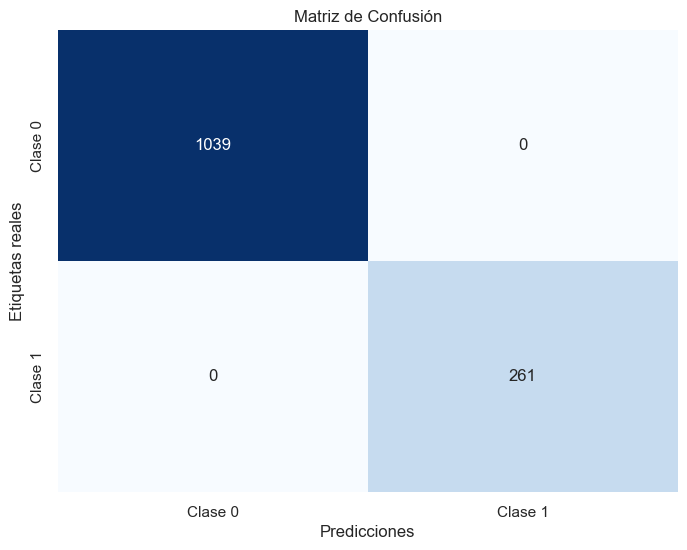

In [340]:
model = RandomForestClassifier()
y_pred = make_prediction(model, X_train, y_train, X_test)
verify_results(y_test, y_pred)

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1039
           1       0.88      0.92      0.90       261

    accuracy                           0.96      1300
   macro avg       0.93      0.94      0.94      1300
weighted avg       0.96      0.96      0.96      1300



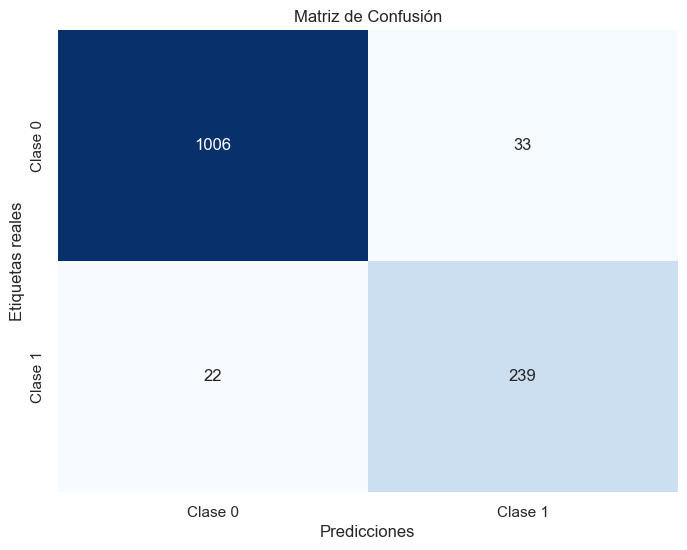

In [341]:
xgbc = XGBClassifier()

y_pred = make_prediction(xgbc, X_train, y_train, X_test)
verify_results(y_test, y_pred)

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1039
           1       1.00      0.01      0.02       261

    accuracy                           0.80      1300
   macro avg       0.90      0.50      0.45      1300
weighted avg       0.84      0.80      0.71      1300



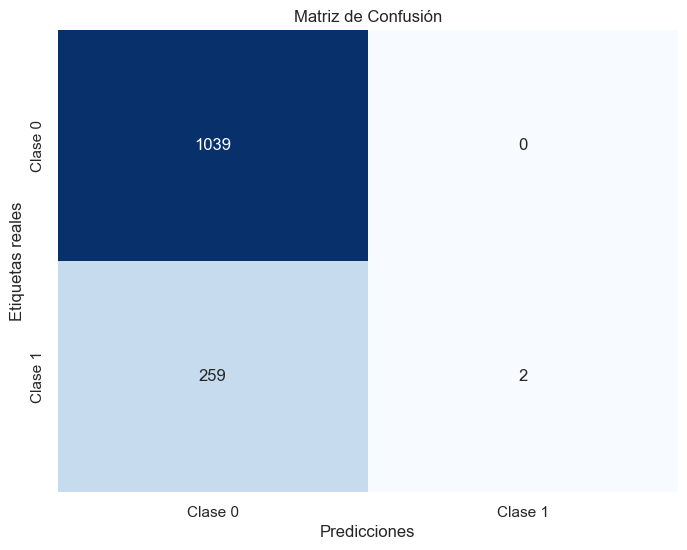

In [342]:
gb_classifier = GradientBoostingClassifier(loss='exponential', learning_rate=0.1)

y_pred = make_prediction(gb_classifier, X_train, y_train, X_test)
verify_results(y_test, y_pred)

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1039
           1       0.67      0.01      0.02       261

    accuracy                           0.80      1300
   macro avg       0.73      0.50      0.45      1300
weighted avg       0.77      0.80      0.71      1300



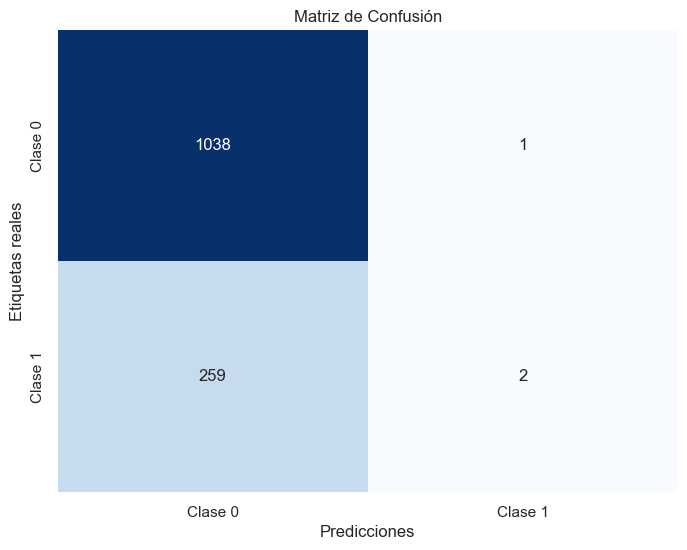

In [343]:
adaboost_classifier = AdaBoostClassifier()

y_pred = make_prediction(adaboost_classifier, X_train, y_train, X_test)
verify_results(y_test, y_pred)


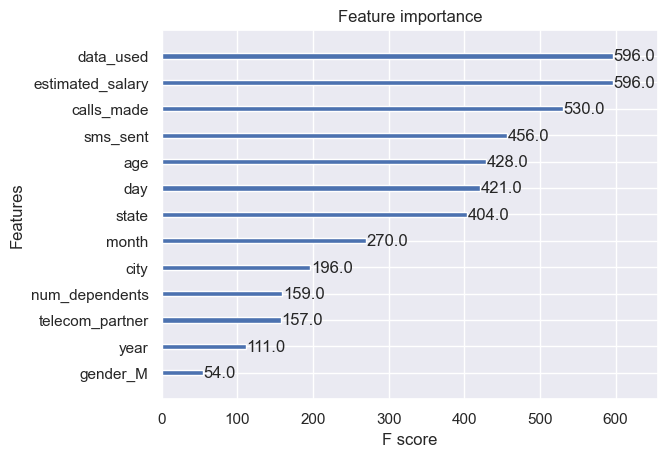

In [344]:
# Plot feature importances
plot_importance(xgbc)
plt.show()


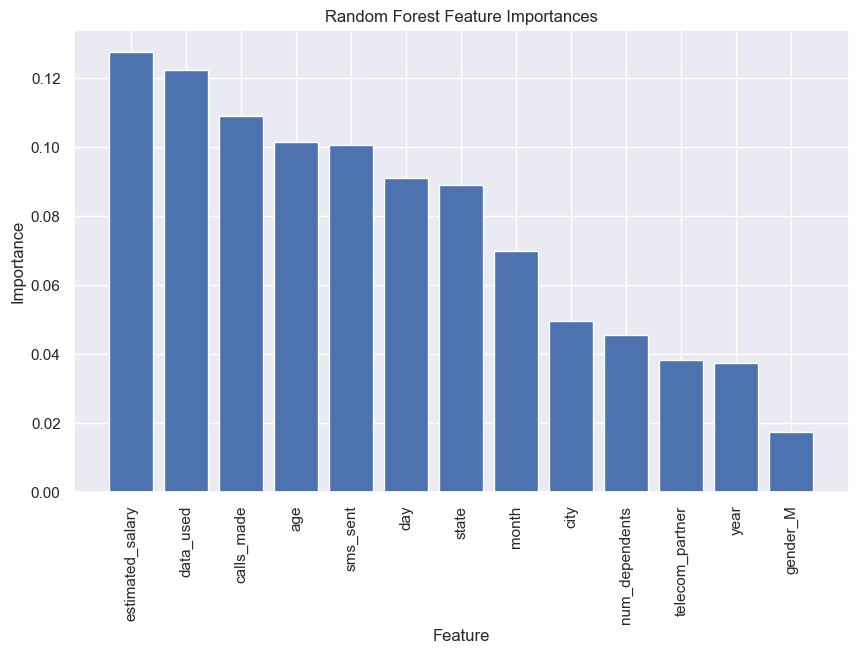

In [345]:
# Get feature importances
feature_importances = model.feature_importances_
feature_names = X_train.columns  # Assuming you have named columns in your DataFrame

# Sort feature importances in descending order
indices = feature_importances.argsort()[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[indices])
plt.xticks(range(len(feature_importances)), feature_names[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importances")
plt.show()

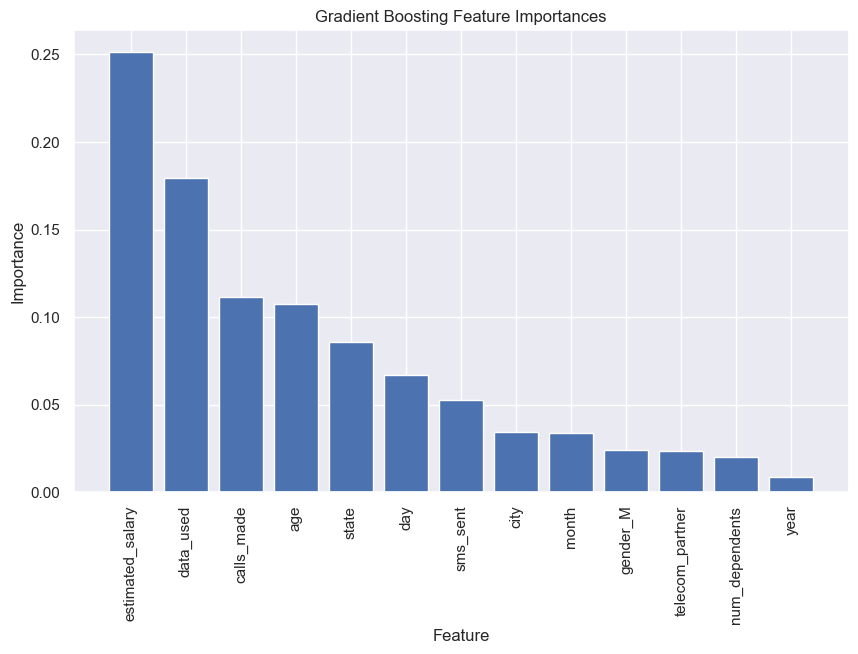

In [346]:
# Get feature importances
feature_importances = gb_classifier.feature_importances_
feature_names = X_train.columns  # Assuming you have named columns in your DataFrame

# Sort feature importances in descending order
indices = feature_importances.argsort()[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[indices])
plt.xticks(range(len(feature_importances)), feature_names[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Gradient Boosting Feature Importances")
plt.show()

In [406]:
X= df_pre_processed[['estimated_salary', 'data_used', 'calls_made', 'age', 'sms_sent', 'state']]
y= df_pre_processed['churn']

# Dividir los datos en entrenamiento y test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


undersampler = RandomUnderSampler(sampling_strategy=0.30, random_state=42)

X_train, y_train = undersampler.fit_resample(X, y)

print ("Distribution before resampling {}".format(Counter(y)))

print ("Distribution labels after resampling {}".format(Counter(y_train)))

Distribution before resampling Counter({0: 5197, 1: 1303})
Distribution labels after resampling Counter({0: 4343, 1: 1303})


In [409]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

xgbc = XGBClassifier(objective='binary:logistic', learning_rate= 0.7, n_estimators= 500, max_depth=6, device = 'cuda', min_child_weight = 0.5,reg_alpha = 0.1, reg_lambda = 0.1)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cross_val_results = cross_val_score(xgbc, X, y, cv=cv, scoring='accuracy')

print(f'Precisión para cada fold: {cross_val_results}')
print(f'Precisión media: {cross_val_results.mean()}')

Precisión para cada fold: [0.74461538 0.75384615 0.74       0.74461538 0.75846154 0.75384615
 0.75076923 0.73692308 0.71692308 0.72769231]
Precisión media: 0.7427692307692307


In [399]:
lr = LogisticRegression(penalty='l2', C=100, fit_intercept=True, class_weight={0:0.80, 1:0.20}, warm_start=True)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cross_val_results = cross_val_score(lr, X, y, cv=cv, scoring='accuracy')

print(f'Precisión para cada fold: {cross_val_results}')
print(f'Precisión media: {cross_val_results.mean()}')

Precisión para cada fold: [0.79846154 0.79846154 0.79846154 0.8        0.8        0.8
 0.8        0.8        0.8        0.8       ]
Precisión media: 0.7995384615384615


In [400]:
gbc = GradientBoostingClassifier(
    n_estimators=100,  
    learning_rate=0.1,  
    max_depth=12,        
    random_state=42,
    ccp_alpha=0.1)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cross_val_results = cross_val_score(gbc, X, y, cv=cv, scoring='accuracy')

print(f'Precisión para cada fold: {cross_val_results}')
print(f'Precisión media: {cross_val_results.mean()}')

Precisión para cada fold: [0.79846154 0.79846154 0.79846154 0.8        0.8        0.8
 0.8        0.8        0.8        0.8       ]
Precisión media: 0.7995384615384615


In [401]:
rf_classifier = RandomForestClassifier(
    n_estimators=100,      
    criterion='gini',      
    max_depth=None,         
    min_samples_split=8,    
    min_samples_leaf=2,     
    random_state=42         
)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cross_val_results = cross_val_score(rf_classifier, X, y, cv=cv, scoring='accuracy')

print(f'Precisión para cada fold: {cross_val_results}')
print(f'Precisión media: {cross_val_results.mean()}')

Precisión para cada fold: [0.79846154 0.8        0.79846154 0.8        0.8        0.79846154
 0.79846154 0.8        0.8        0.79692308]
Precisión media: 0.799076923076923


In [402]:
adaboost_classifier = AdaBoostClassifier(
    estimator=None,   
    n_estimators=500,        
    learning_rate=0.1,      
    algorithm='SAMME.R',    
    random_state=42         
)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cross_val_results = cross_val_score(adaboost_classifier, X, y, cv=cv, scoring='accuracy')

print(f'Precisión para cada fold: {cross_val_results}')
print(f'Precisión media: {cross_val_results.mean()}')

Precisión para cada fold: [0.79846154 0.79846154 0.79846154 0.8        0.8        0.8
 0.8        0.8        0.8        0.8       ]
Precisión media: 0.7995384615384615


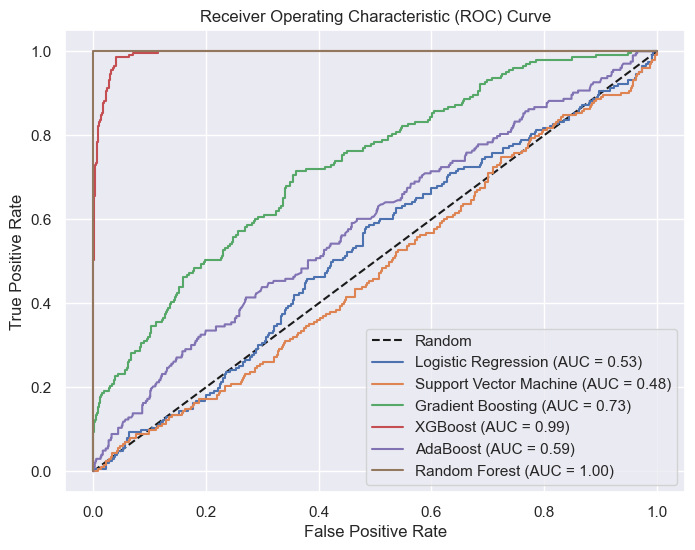

In [403]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier

# Supongamos que tienes datos X (características) y y (etiquetas)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar modelos
models = {
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine': SVC(probability=True),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Configurar el gráfico ROC
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Calcular la curva ROC y el área bajo la curva para cada modelo
for name, model in models.items():
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Obtener probabilidades predichas para la clase positiva
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calcular la curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    
    # Calcular el área bajo la curva ROC
    roc_auc = auc(fpr, tpr)
    
    # Graficar la curva ROC
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Configurar el gráfico
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Todos los modelos están teniendo un valor similar para la validación cruzada, puede deberser a la poca cantidad de datos, sin embargo al entrenar los modelos , el modelo más efectivo es el de XGBoost y RandomForest.